In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llama-3.1/transformers/8b-instruct/1/model.safetensors.index.json
/kaggle/input/llama-3.1/transformers/8b-instruct/1/model-00003-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/1/config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/1/model-00001-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/1/README.md
/kaggle/input/llama-3.1/transformers/8b-instruct/1/USE_POLICY.md
/kaggle/input/llama-3.1/transformers/8b-instruct/1/tokenizer.json
/kaggle/input/llama-3.1/transformers/8b-instruct/1/tokenizer_config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/1/model-00004-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/1/special_tokens_map.json
/kaggle/input/llama-3.1/transformers/8b-instruct/1/model-00002-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/1/generation_config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model.safetensors.index.json
/kaggle/input/llama-3.1/tra

In [3]:
%%capture
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl

In [4]:
!pip install wandb
#!wandb login

In [5]:
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wb_token = user_secrets.get_secret("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune llama-3.1-8b-it on Newspaper Dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cse-mahmud-evan (cse-mahmud-evan-ccn-university-of-science-and-technology). Use `wandb login --relogin` to force relogin


In [6]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging
)
from sklearn.metrics import (

    accuracy_score,
    classification_report,
    confusion_matrix   
)
from sklearn.model_selection import train_test_split

In [7]:
import numpy as np
import pandas as pd

data = pd.read_json('/kaggle/input/bangla-newspaper-dataset/data_v2/data_v2.json')
data.head()

,author,category,category_bn,published_date,modification_date,tag,comment_count,title,url,content
0,গাজীপুর প্রতিনিধি,bangladesh,বাংলাদেশ,"০৪ জুলাই ২০১৩, ২৩:২৬","০৪ জুলাই ২০১৩, ২৩:২৭",[গাজীপুর],0,"কালিয়াকৈরে টিফিন খেয়ে ৫০০ শ্রমিক অসুস্থ, বিক...",http://www.prothom-alo.com/bangladesh/article/...,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...
1,অনলাইন ডেস্ক,sports,খেলা,"০৪ জুলাই ২০১৩, ২৩:০৯","০৪ জুলাই ২০১৩, ২৩:১১",[টেনিস],0,সেমিফাইনাল বাধাও পেরিয়ে গেলেন লিসিকি,http://www.prothom-alo.com/sports/article/19028,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...
2,নিজস্ব প্রতিবেদক,bangladesh,বাংলাদেশ,"০৪ জুলাই ২০১৩, ২২:২৫","০৪ জুলাই ২০১৩, ২৩:১২",[রাজনীতি],0,সংসদে খালেদার অভিযোগের জবাব দিয়েছে ভারত,http://www.prothom-alo.com/bangladesh/article/...,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...
3,অনলাইন ডেস্ক,technology,বিজ্ঞান ও প্রযুক্তি,"০৪ জুলাই ২০১৩, ২১:৩৭","০৪ জুলাই ২০১৩, ২১:৪৫",[গবেষণা],0,পাসওয়ার্ড ভুলে যান!,http://www.prothom-alo.com/technology/article/...,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...
4,অনলাইন ডেস্ক,technology,বিজ্ঞান ও প্রযুক্তি,"০৪ জুলাই ২০১৩, ২১:৩৫","০৪ জুলাই ২০১৩, ২১:৩৭",[কম্পিউটার],0,চলে গেলেন মাউস উদ্ভাবক,http://www.prothom-alo.com/technology/article/...,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...


In [8]:
len(data.columns)

10

In [9]:
ndf = data[['content','category']]

In [10]:
ndf.shape

(408471, 2)

In [11]:
ndf.duplicated().sum()

1567

In [12]:
ndf.drop_duplicates(inplace= True)

/tmp/ipykernel_30/3272145479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf.drop_duplicates(inplace= True)


In [13]:
ndf.shape

(406904, 2)

In [14]:
ndf.category.unique()

array(['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education'],
      dtype=object)

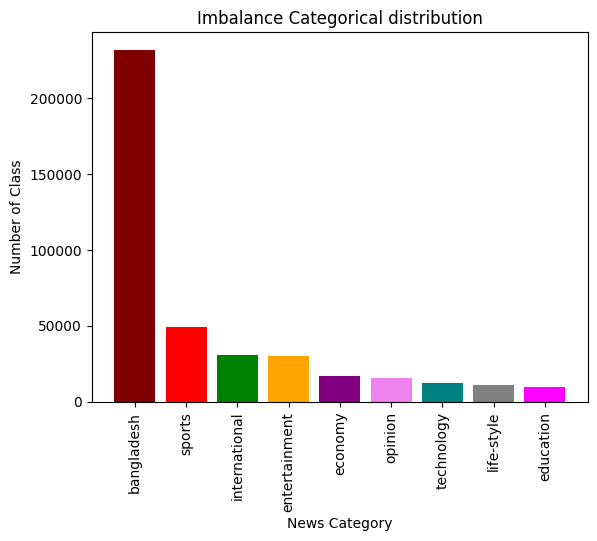

In [15]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt


color_palette = ['maroon', 'red', 'green', 'orange', 'purple', 'violet','teal','gray','magenta']

labels = ndf['category'].value_counts().index
values = ndf['category'].value_counts().values

plt.bar(labels,values, color = color_palette)
plt.title("Imbalance Categorical distribution")
plt.xticks(rotation=90)
plt.xlabel('News Category')
plt.ylabel('Number of Class')



plt.show()

In [16]:
'''from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
ndf['category'] = lbl.fit_transform(ndf['category'])'''

"from sklearn.preprocessing import LabelEncoder\nlbl = LabelEncoder()\nndf['category'] = lbl.fit_transform(ndf['category'])"

In [17]:
ndf.head()

,content,category
0,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...,bangladesh
1,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...,sports
2,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...,bangladesh
3,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...,technology
4,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...,technology


In [18]:
!pip install imblearn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [19]:

from imblearn.under_sampling import RandomUnderSampler

A = ndf.drop('category',axis = 1)
b = ndf['category']

rus = RandomUnderSampler()

A_resampled, b_resampled = rus.fit_resample(A,b)

resampled_df = pd.DataFrame(A_resampled,columns = A.columns)
resampled_df['category'] = b_resampled

resampled_df = resampled_df.sample(frac = 1, random_state = 85).reset_index (drop=True)

In [20]:
resampled_df.head()

,content,category
0,মাইক্রোসফটের জনপ্রিয় অপারেটিং সিস্টেমের মধ্যে ...,technology
1,সম্প্রতি ইউনাইটেড হসপিটাল লিমিটেড ও স্যার জন উ...,economy
2,বাংলা নববর্ষ উপলক্ষে বিচিত্র সব বিনোদনে ভরে ওঠ...,life-style
3,"পণ্ডিতদের ম‌তে, দুর্যোগ কোনো সংকট নয়, এটা একট...",opinion
4,"অধ্যায়-৩ প্রিয় শিক্ষার্থী, আজ প্রাথমিক বিজ্ঞা...",education


In [21]:
resampled_df.shape

(86868, 2)

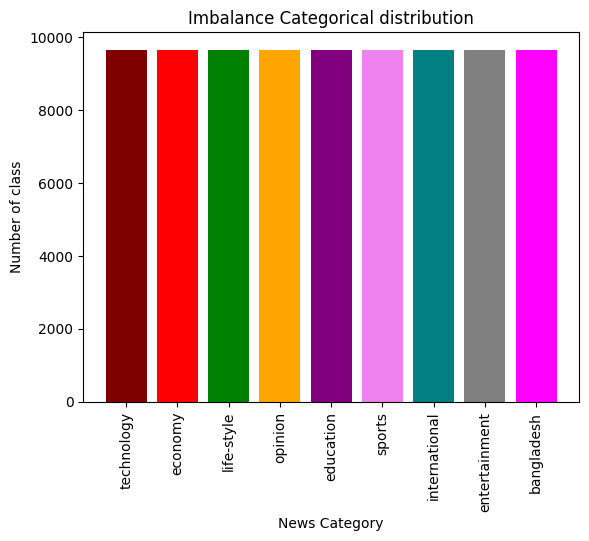

In [22]:
#category distribution
labels = resampled_df['category'].value_counts().index
values = resampled_df['category'].value_counts().values

color_palette = ['maroon', 'red', 'green', 'orange', 'purple', 'violet','teal','gray','magenta']

#plot bar chart
plt.bar(labels,values, color = color_palette)
plt.title('Imbalance Categorical distribution')
plt.xticks(rotation=90)
plt.xlabel('News Category')
plt.ylabel('Number of class')
plt.show()

In [23]:
resampled_df['category'].value_counts()

category
technology       9652
economy          9652
life-style       9652
opinion          9652
education        9652
sports           9652
international    9652
entertainment    9652
bangladesh       9652
Name: count, dtype: int64

In [24]:
ndf = resampled_df.sample(frac= 1, random_state = 48).reset_index(drop=True).head(1000)
ndf.head()

,content,category
0,আগামী মার্কিন প্রেসিডেন্ট নির্বাচনে প্রতিদ্বন্...,international
1,এবার রমজান মাসে বিশ্বকাপের খেলা পড়েছে বাংলাদেশ...,sports
2,নক্ষত্রেরও মৃত্যু হয়। আর তখন ঘটে গামা রশ্মির ম...,technology
3,স্প্যানিশ চিত্রশিল্পী পাবলো পিকাসোর একটি চিত...,international
4,মাগুরায় খেলতে গেছে বাংলাদেশ প্রিমিয়ার লিগের চ্...,sports


In [25]:
train_size = 0.8
val_size = 0.1

train_end = int(train_size * len(ndf)) 
val_end = train_end + int(val_size * len(ndf))


In [26]:
X_train = ndf[:train_end]
X_val = ndf[train_end:val_end]
X_test = ndf[val_end:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(800, 2)
(100, 2)
(100, 2)


In [27]:
# Define the prompt generation functions
def generate_prompt(data_point):
    return f"""
            Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.
text: {data_point["content"]}
label: {data_point["category"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.
text: {data_point["content"]}
label: """.strip()

In [28]:
X_train.loc[:,'text'] = X_train.apply(generate_prompt,axis = 1)
X_train.head()

/tmp/ipykernel_30/605730108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,'text'] = X_train.apply(generate_prompt,axis = 1)


,content,category,text
0,আগামী মার্কিন প্রেসিডেন্ট নির্বাচনে প্রতিদ্বন্...,international,"Classify the text into bangladesh, sports, tec..."
1,এবার রমজান মাসে বিশ্বকাপের খেলা পড়েছে বাংলাদেশ...,sports,"Classify the text into bangladesh, sports, tec..."
2,নক্ষত্রেরও মৃত্যু হয়। আর তখন ঘটে গামা রশ্মির ম...,technology,"Classify the text into bangladesh, sports, tec..."
3,স্প্যানিশ চিত্রশিল্পী পাবলো পিকাসোর একটি চিত...,international,"Classify the text into bangladesh, sports, tec..."
4,মাগুরায় খেলতে গেছে বাংলাদেশ প্রিমিয়ার লিগের চ্...,sports,"Classify the text into bangladesh, sports, tec..."


In [29]:
X_val.loc[:,'text'] = X_val.apply(generate_prompt, axis=1)
X_val.head()

/tmp/ipykernel_30/1181508762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.loc[:,'text'] = X_val.apply(generate_prompt, axis=1)


,content,category,text
800,মিয়ানমারের উত্তরাঞ্চলের মান্দালয় শহরের বাসিন্দ...,international,"Classify the text into bangladesh, sports, tec..."
801,২৯ জানুয়ারি শেরপুর সরকারি মহিলা কলেজে অনুষ্ঠিত...,life-style,"Classify the text into bangladesh, sports, tec..."
802,বাংলাদেশে আশ্রয় নেওয়া রোহিঙ্গাদের জন্য মার্কিন...,international,"Classify the text into bangladesh, sports, tec..."
803,সিডনি টেস্টে ডেভিড ওয়ার্নারকে নিয়েই মেতে থাকার...,sports,"Classify the text into bangladesh, sports, tec..."
804,সিরিয়ার রাসায়নিক অস্ত্র ধ্বংসের কাজে সহায়তা দি...,international,"Classify the text into bangladesh, sports, tec..."


In [30]:
X_test.head()

,content,category
900,এমনিতেও হলিউডের তারকা লিন্ডসে লোহানের সমালোচনা...,entertainment
901,হাইওয়ে থেকে যে রাস্তা ঢুকে এঁকেবেঁকে চলে গেল অ...,life-style
902,"আজকাল প্রায়ই মা-বাবাকে বলতে শোনা যায়, বাচ্চারা...",life-style
903,দেশ থেকে দুর্নীতিগ্রস্ত শাসকদের হটাতে দৃঢ়প্রত্...,international
904,সংখ্যালঘু রোহিঙ্গা সম্প্রদায়ের বিরুদ্ধে বৈষম্য...,international


In [31]:
y_true = X_test.loc[:,'category']
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis = 1), columns = ['text'])

In [32]:
X_test.head()

,text
900,"Classify the text into bangladesh, sports, tec..."
901,"Classify the text into bangladesh, sports, tec..."
902,"Classify the text into bangladesh, sports, tec..."
903,"Classify the text into bangladesh, sports, tec..."
904,"Classify the text into bangladesh, sports, tec..."


In [33]:
X_val.shape

(100, 3)

In [34]:
y_true.head()

900    entertainment
901       life-style
902       life-style
903    international
904    international
Name: category, dtype: object

In [35]:
X_test.head()

,text
900,"Classify the text into bangladesh, sports, tec..."
901,"Classify the text into bangladesh, sports, tec..."
902,"Classify the text into bangladesh, sports, tec..."
903,"Classify the text into bangladesh, sports, tec..."
904,"Classify the text into bangladesh, sports, tec..."


In [36]:
X_train.category.value_counts()

category
life-style       102
opinion           96
education         95
sports            91
economy           88
international     85
technology        84
bangladesh        82
entertainment     77
Name: count, dtype: int64

In [37]:
y_true.value_counts()

category
life-style       18
bangladesh       15
education        13
opinion          12
entertainment    10
sports           10
international    10
economy           7
technology        5
Name: count, dtype: int64

In [38]:
from datasets import Dataset
# Convert to datasets
train_data = Dataset.from_pandas(X_train[["text"]])
val_data = Dataset.from_pandas(X_val[["text"]])

In [39]:
print(train_data)
print(val_data)

Dataset({
    features: ['text'],
    num_rows: 800
})
Dataset({
    features: ['text'],
    num_rows: 100
})


In [40]:
train_data['text'][3]

'Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.\ntext: স্প্যানিশ চিত্রশিল্পী পাবলো পিকাসোর একটি চিত্রকর্ম প্রত্যাশার চেয়ে অনেক বেশি দামে নিলামে বিক্রি হয়েছে৷ ‘ল্য সভতাজ’ নামের তৈলচিত্রটি বিক্রি হয়েছে তিন কোটি ১৫ লাখ মার্কিন ডলারের বেশি দামে৷পিকাসো তাঁর ‘ল্য চিত্রকর্মটি অঁাকেন ১৯৩২ সালে৷ এটি সর্বশেষ হাতবদল হয়েছিল প্রায় এক দশক আগে৷ গত বুধবার আবার তা নিলামের আয়োজন করে িনউইয়র্কভিত্তিক নিলাম প্রতিষ্ঠান সাদাবি’জ৷ ধারণা করা হয়েছিল, এক কোটি ৪০ থেকে এক কোটি ৮০ লাখ ডলারের মধ্যে এটি বিক্রি হতে পারে৷ কিন্তু এই প্রত্যাশার চেয়ে অনেক বেশি—তিন কোটি ১৫ লাখ ২৫ হাজার ডলারে চিত্রকর্মটি কিনে নেন এক ব্যক্তি৷ আধুনিক শিল্পকলার আরও কয়েকজন বিখ্যাত শিল্পীর চিত্রকর্মের সঙ্গে পিকাসোর ১৪টি শিল্পকর্ম নিলামে তোলা হয় এবার৷ এএফপি৷\nlabel: international'

In [41]:
base_model_name = '/kaggle/input/llama-3.1/transformers/8b-instruct/2'

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = False,
    bnb_4bit_quant_type = 'nf4',
    llm_int8_enable_fp32_cpu_offload=True,
    bnb_4bit_compute_dtype = 'float16')


model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    quantization_config=bnb_config, 
)

model.config._use_cache = False
model.config.pretaining_tp = 1

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [42]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token_id  = tokenizer.eos_token_id

In [43]:
def predict(test,model,tokenizer):
    y_pred = []
    categories = ['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education']


    
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens=2, 
                        temperature=0.1,
                        torch_dtype=torch.float16)
        
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()
        
        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")
    
    return y_pred

In [44]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 100/100 [09:47<00:00,  5.87s/it]


In [45]:
def evaluate(y_true, y_pred):
    labels = ['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education']
    mapping = {label: idx for idx, label in enumerate(labels)}
    
    def map_func(x):
        return mapping.get(x, -1)  # Map to -1 if not found, but should not occur with correct data
    
    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [46]:
evaluate(y_true, y_pred)

Accuracy: 0.530
Accuracy for label bangladesh: 0.867
Accuracy for label sports: 0.300
Accuracy for label technology: 0.000
Accuracy for label entertainment: 0.200
Accuracy for label international: 0.600
Accuracy for label economy: 0.714
Accuracy for label life-style: 0.778
Accuracy for label opinion: 0.250
Accuracy for label education: 0.538

Classification Report:
               precision    recall  f1-score   support

   bangladesh       0.28      0.87      0.43        15
       sports       1.00      0.30      0.46        10
   technology       0.00      0.00      0.00         5
entertainment       1.00      0.20      0.33        10
international       0.75      0.60      0.67        10
      economy       0.71      0.71      0.71         7
   life-style       0.78      0.78      0.78        18
      opinion       0.50      0.25      0.33        12
    education       0.70      0.54      0.61        13

     accuracy                           0.53       100
    macro avg       0.64 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [48]:
modules = find_all_linear_names(model)
modules

['up_proj', 'k_proj', 'v_proj', 'o_proj', 'q_proj', 'gate_proj', 'down_proj']

In [49]:
output_dir="llama-3.1 8b model"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    logging_steps=1,                         
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="wandb",                  # report metrics to w&b
    eval_strategy="steps",              # save checkpoint every epoch
    eval_steps = 0.2
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=val_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=256,
    packing=False,
    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_kwargs. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:327: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you pass

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [50]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), d

Step,Training Loss,Validation Loss
20,0.711900,0.735616
40,0.701400,0.719641
60,0.827800,0.706061
80,0.733200,0.700276
100,0.654600,0.698876


TrainOutput(global_step=100, training_loss=0.7443504810333252, metrics={'train_runtime': 2218.4984, 'train_samples_per_second': 0.361, 'train_steps_per_second': 0.045, 'total_flos': 9266074364264448.0, 'train_loss': 0.7443504810333252, 'epoch': 1.0})

In [51]:
wandb.finish()
model.config.use_cache = True

eval/loss,█▅▂▁▁
eval/runtime,▁█▄▅▄
eval/samples_per_second,█▁▅▅▅
eval/steps_per_second,▁▁▁▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
train/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇████
train/grad_norm,▁▂▃▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▃▆██████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train/loss,██▇▃▂▂▂▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▁▁▂▃▂▂▁▂▂▂▂▂▂▁▁▁▁▁
eval/loss,0.69888
eval/runtime,55.0878


In [52]:
#Save Train Model and Tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-3.1 8b model/tokenizer_config.json',
 'llama-3.1 8b model/special_tokens_map.json',
 'llama-3.1 8b model/tokenizer.json')

In [53]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 100/100 [10:23<00:00,  6.24s/it]


In [54]:
evaluate(y_true, y_pred)

Accuracy: 0.460
Accuracy for label bangladesh: 0.133
Accuracy for label sports: 0.500
Accuracy for label technology: 0.400
Accuracy for label entertainment: 0.900
Accuracy for label international: 0.100
Accuracy for label economy: 0.857
Accuracy for label life-style: 0.556
Accuracy for label opinion: 0.750
Accuracy for label education: 0.154

Classification Report:
               precision    recall  f1-score   support

   bangladesh       0.50      0.13      0.21        15
       sports       1.00      0.50      0.67        10
   technology       1.00      0.40      0.57         5
entertainment       0.64      0.90      0.75        10
international       1.00      0.10      0.18        10
      economy       0.30      0.86      0.44         7
   life-style       0.91      0.56      0.69        18
      opinion       0.23      0.75      0.35        12
    education       0.50      0.15      0.24        13

     accuracy                           0.46       100
    macro avg       0.68 

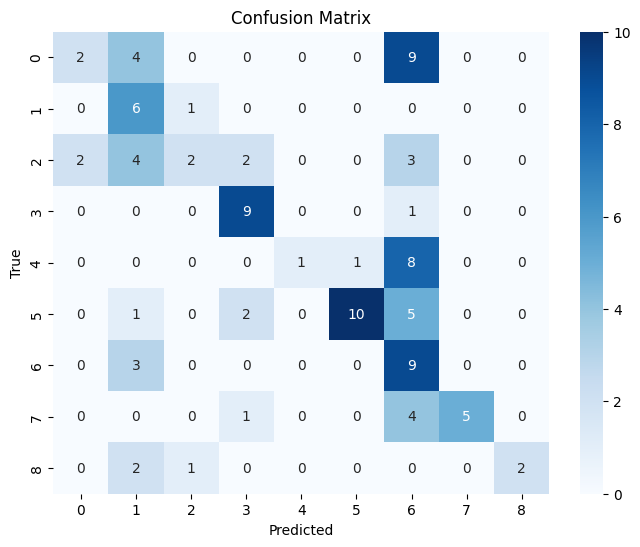

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [56]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
